In [1]:
import os
import numpy as np
import scipy
from scipy import integrate
import matplotlib.pyplot as plt
import camb
from camb import model
from jupyterthemes import jtplot
import math
import time
import h5py
import sys
moments_path = os.path.realpath(os.path.join('/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/gen_moments/Moments_analysis/'))
sys.path.insert(0, moments_path)
import h5py as h5
import healpy as hp
import pickle
import copy
def save_obj(name, obj):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, protocol = 2)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)#, encoding='latin1')

jtplot.reset()
from tqdm import tqdm



In [70]:
def filter_full_data(data_full, params):
    filter_type = params['type']
    
    sm_all = data_full['sm_all']
    id_kp2_all_finite = data_full['id_kp2_all_finite'][0,:,:].T
    ind_filter_kp2 = []
    for jid in range(len(id_kp2_all_finite)):
        jz1, jz2, i, j = id_kp2_all_finite[jid]
        
        if filter_type == 'auto_zbin':
            if jz1 == jz2:
                ind_filter_kp2.append(jid)
                
        if filter_type == 'simple_test':
            if (jz1 == jz2) and (jz2==3) and (i==j):
                ind_filter_kp2.append(jid)
                

        if filter_type == 'auto_smbin':
            if i == j:
                # print(jz1, jz2, i, j)
                ind_filter_kp2.append(jid)

        if filter_type == 'auto_zbin_gtsc':
            sc_all = params['sc_all']
            if jz1 == jz2:
                if (sm_all[i] > sc_all[jz1]) & (sm_all[j] > sc_all[jz2]):
                    ind_filter_kp2.append(jid)

        if filter_type == 'auto_smbin_gtsc':
            sc_all = params['sc_all']            
            if i == j:
                if (sm_all[i] > sc_all[jz1]) & (sm_all[j] > sc_all[jz2]):
                    ind_filter_kp2.append(jid)

        if filter_type == 'all_gtsc':
            sc_all = params['sc_all']            
            if (sm_all[i] > sc_all[jz1]) & (sm_all[j] > sc_all[jz2]):
                ind_filter_kp2.append(jid)
                
        if filter_type == 'all':
            ind_filter_kp2.append(jid)                
                
    ind_filter_kp2 = np.array(ind_filter_kp2)
    data_kp2_lhs_filter = data_full['kp2_all_lhs'][:, ind_filter_kp2]

    id_kp3_all_finite = data_full['id_kp3_all_finite'][0,:,:].T
    ind_filter_kp3 = []
    for jid in range(len(id_kp3_all_finite)):
        jz1, jz2, jz3, i, j, k = id_kp3_all_finite[jid]
        if filter_type == 'auto_zbin':
            if (jz1 == jz2) and (jz2 == jz3):
                ind_filter_kp3.append(jid)
                
        if filter_type == 'simple_test':
            if (jz1 == jz2) and (jz2==jz3) and (jz2==3) and (i==j) and (j==k):
                ind_filter_kp3.append(jid)
                

        if filter_type == 'auto_smbin':
            if (i == j) and (j == k):
                # print(jz1, jz2, jz3, i, j, k)
                ind_filter_kp3.append(jid)

        if filter_type == 'auto_zbin_gtsc':
            sc_all = params['sc_all']
            if (jz1 == jz2) and (jz2 == jz3):
                if (sm_all[i] > sc_all[jz1]) & (sm_all[j] > sc_all[jz2]) & (sm_all[k] > sc_all[jz3]):
                    ind_filter_kp3.append(jid)

        if filter_type == 'auto_smbin_gtsc':
            sc_all = params['sc_all']            
            if (i == j) and (j == k):
                if (sm_all[i] > sc_all[jz1]) & (sm_all[j] > sc_all[jz2]) & (sm_all[k] > sc_all[jz3]):
                    ind_filter_kp3.append(jid)

        if filter_type == 'all_gtsc':
            sc_all = params['sc_all']            
            if (sm_all[i] > sc_all[jz1]) & (sm_all[j] > sc_all[jz2]) & (sm_all[k] > sc_all[jz3]):
                ind_filter_kp3.append(jid)
                
        if filter_type == 'all':
            ind_filter_kp3.append(jid)                
                
                
    ind_filter_kp3 = np.array(ind_filter_kp3)
    data_kp3_lhs_filter = data_full['kp3_all_lhs'][:, ind_filter_kp3]

    return data_kp2_lhs_filter, data_kp3_lhs_filter, ind_filter_kp2, ind_filter_kp3
    



In [71]:
jr_lhs = 0
nsamp_lhs = 50000
sdir = '/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/saveDVs/'
# data_full = pk.load(open(sdir + 'newIA/' + 'COMBINED_lhs_n' + str(nsamp_lhs) + '_jr' + str(jr_lhs) + '.pk','rb'))
fname = sdir + 'newIA/' + 'COMBINED_lhs_n' + str(nsamp_lhs) + '_jr' + str(jr_lhs) + '.pk'
# np.save(fname, saved, allow_pickle=True)
import h5py
hf = h5py.File(fname, 'r')




In [72]:
data_full = {'kp2_all_lhs':hf['kp2_all_lhs'], 'kp3_all_lhs':hf['kp3_all_lhs'], 
         'id_kp2_all_finite':hf['id_kp2_all_finite'],
        'id_kp3_all_finite':hf['id_kp3_all_finite'],
         'sm_all':hf['sm_all']
        }




In [73]:
# params_filter = {'type':'auto_smbin'}
params_filter = {'type':'simple_test'}
# params_filter = {'type':'all'}
kp2_all_lhs, kp3_all_lhs, ind_filter_kp2, ind_filter_kp3 = filter_full_data(data_full, params_filter)



In [74]:
nsim2, ncomp2 = kp2_all_lhs.shape[0], kp2_all_lhs.shape[1] 
nsim3, ncomp3 = kp3_all_lhs.shape[0], kp3_all_lhs.shape[1] 
# nsim23, ncomp23 = kp2_kp3_all_lhs.shape[0], kp2_kp3_all_lhs.shape[1] 




In [75]:
df = pk.load(open('/global/cfs/cdirs/des/shivamp/cosmosis2p0/cosmosis-standard-library/gen_moments/fid_sim_measurements.pk','rb'))  

# saved = {'kp2_all_fid':kp2_all_fid, 'kp3_all_fid':kp3_all_fid, 'kp3_all_data':kp3_all_data, 'kp2_all_data':kp2_all_data}
kp2_all_fid = df['kp2_all_fid']
kp3_all_fid = df['kp3_all_fid']
kp3_all_data = df['kp3_all_data']
kp2_all_data = df['kp2_all_data']




In [76]:
do_div_fid = False
if do_div_fid:
    kp2_all_fid_mat = np.tile(kp2_all_fid[ind_filter_kp2].reshape(1, ncomp2), (nsim2, 1))
    kp3_all_fid_mat = np.tile(kp3_all_fid[ind_filter_kp3].reshape(1, ncomp3), (nsim3, 1))
else:
    kp2_all_fid_mat = np.tile(np.ones_like(ind_filter_kp2).reshape(1, ncomp2), (nsim2, 1))
    kp3_all_fid_mat = np.tile(np.ones_like(ind_filter_kp3).reshape(1, ncomp3), (nsim3, 1))
    


In [77]:
nsim2_data, nsim3_data = kp2_all_data.shape[0], kp3_all_data.shape[0]
if do_div_fid:
    kp2_all_fid_mat2 = np.tile(kp2_all_fid[ind_filter_kp2].reshape(1, ncomp2), (nsim2_data, 1))
    kp3_all_fid_mat2 = np.tile(kp3_all_fid[ind_filter_kp3].reshape(1, ncomp3), (nsim3_data, 1))
else:
    kp2_all_fid_mat2 = np.tile(np.ones_like(ind_filter_kp2).reshape(1, ncomp2), (nsim2_data, 1))
    kp3_all_fid_mat2 = np.tile(np.ones_like(ind_filter_kp3).reshape(1, ncomp3), (nsim3_data, 1))
    




In [78]:
from sklearn.preprocessing import StandardScaler

scaler_kp2 = StandardScaler().fit(kp2_all_lhs)
kp2_all_lhs_normalised = scaler_kp2.transform(kp2_all_lhs)




In [79]:
# from sklearn.preprocessing import StandardScaler

# scaler_kp2_ratio = StandardScaler().fit(kp2_all_lhs/kp2_all_fid_mat)
# kp2_ratio_all_lhs_normalised = scaler_kp2_ratio.transform(kp2_all_lhs/kp2_all_fid_mat)



# # scaler_kp3 = StandardScaler().fit(kp3_all_lhs/kp3_all_fid_mat)
# # kp3_all_lhs_normalised = scaler_kp3.transform(kp3_all_lhs/kp3_all_fid_mat)




In [80]:
kp2_fid = kp2_all_fid[ind_filter_kp2]


In [81]:
# kp2_ratio_all_data_normalised = scaler_kp2_ratio.transform(kp2_all_data[:,ind_filter_kp2]/kp2_all_fid_mat2)
# # kp3_all_data_normalised = scaler_kp3.transform(kp3_all_data[:,ind_filter_kp3]/kp3_all_fid_mat2)
# kp2_ratio_fid_normalised = scaler_kp2_ratio.transform(np.array([kp2_all_fid[ind_filter_kp2]/kp2_all_fid[ind_filter_kp2]]))
# # kp3_fid_normalised = scaler_kp3.transform(np.array([kp3_all_fid[ind_filter_kp3]/kp3_all_fid[ind_filter_kp3]]))








In [97]:
# kp2_all_data_normalised = scaler_kp2.transform(kp2_all_data[:,ind_filter_kp2])
# kp3_all_data_normalised = scaler_kp3.transform(kp3_all_data[:,ind_filter_kp3]/kp3_all_fid_mat2)
# kp2_fid_normalised = scaler_kp2.transform(np.array([kp2_all_fid[ind_filter_kp2]]))
# kp3_fid_normalised = scaler_kp3.transform(np.array([kp3_all_fid[ind_filter_kp3]/kp3_all_fid[ind_filter_kp3]]))




kp2_all_data_normalised = (kp2_all_data[:,ind_filter_kp2])/scaler_kp2.scale_
# kp3_all_data_normalised = scaler_kp3.transform(kp3_all_data[:,ind_filter_kp3]/kp3_all_fid_mat2)
kp2_fid_normalised = (np.array([kp2_all_fid[ind_filter_kp2]]))/scaler_kp2.scale_
# kp3_fid_normalised = scaler_kp3.transform(np.array([kp3_all_fid[ind_filter_kp3]/kp3_all_fid[ind_filter_kp3]]))










In [98]:
# 1/scaler_kp2.scale_
# kp2_all_data_normalised
# kp2_fid_normalised
kp2_all_data[:,ind_filter_kp2].shape, kp2_all_data_normalised.shape




((200, 8), (200, 8))

In [99]:
(kp2_all_data[:,ind_filter_kp2] - scaler_kp2.mean_)/(scaler_kp2.scale_)


array([[-0.60748733, -0.63807304, -0.67084733, ..., -0.7586967 ,
        -0.76802929, -0.76972708],
       [-0.60852304, -0.63936297, -0.66914648, ..., -0.7394813 ,
        -0.75382396, -0.76691865],
       [-0.61203049, -0.6429305 , -0.67330253, ..., -0.74119452,
        -0.73606423, -0.70593315],
       ...,
       [-0.6163801 , -0.64676761, -0.67614286, ..., -0.76911662,
        -0.78775688, -0.78435916],
       [-0.61516956, -0.64424985, -0.6781585 , ..., -0.77402068,
        -0.79570783, -0.78736268],
       [-0.60842256, -0.64034694, -0.67196214, ..., -0.75061491,
        -0.75899036, -0.75758894]])

In [100]:
# kp2_all_data_normalised
# scaler_kp2.scale_



In [101]:
cov_all_data_normalised = np.cov(kp2_all_data_normalised.T)
cov_all_data = np.cov(kp2_all_data[:,ind_filter_kp2].T)



In [104]:
# np.diag(cov_all_data)/np.diag(cov_all_data_normalised)


In [105]:
# cov_all_data
np.sqrt(np.matmul(kp2_fid_normalised,np.matmul(np.linalg.inv(cov_all_data_normalised), kp2_fid_normalised.T)))






array([[16.37446461]])

In [106]:
# cov_all_data
np.sqrt(np.matmul(kp2_fid,np.matmul(np.linalg.inv(cov_all_data), kp2_fid.T)))





16.374464612857146

In [46]:
# kp2_fid.shape, cov_all_data.shape



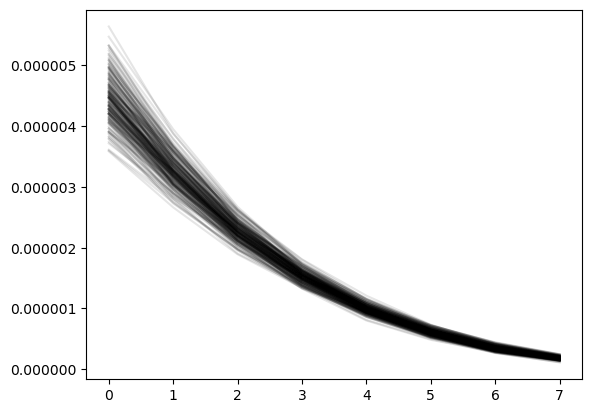

In [107]:
pl.figure()
for ji in range(kp2_all_data.shape[0]):
    # pl.plot(kp2_all_data[ji,ind_filter_kp2]/kp2_all_fid[ind_filter_kp2], color='k', alpha=0.1)
    # pl.plot(kp2_all_data[ji,ind_filter_kp2]/np.mean(kp2_all_data[:,ind_filter_kp2], axis=0), color='k', alpha=0.1)    
    pl.plot(kp2_all_data[ji,ind_filter_kp2], color='k', alpha=0.1)        
pl.show()



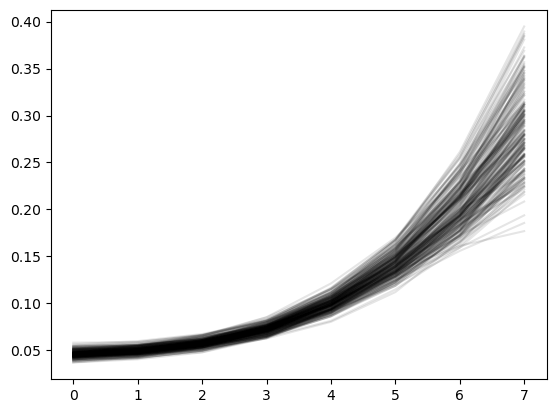

In [108]:
pl.figure()
for ji in range(kp2_all_data_normalised.shape[0]):
    # pl.plot((kp2_all_data_normalised[ji,:]/kp2_fid_normalised)[0,:], color='k', alpha=0.1)
    # pl.plot((kp2_all_data_normalised[ji,:]/np.mean(kp2_all_data_normalised, axis=0)), color='k', alpha=0.1)
    pl.plot((kp2_all_data_normalised[ji,:]), color='k', alpha=0.1)    
    # print(kp2_all_data_normalised[ji,:]/kp2_fid_normalised)
pl.show()




In [92]:
# kp2_fid_normalised
np.mean(kp2_all_data_normalised, axis=0)


array([-0.61238361, -0.64276561, -0.67276664, -0.70123982, -0.73052417,
       -0.75735699, -0.77484755, -0.77187509])

In [20]:
kp2_all_fid[ind_filter_kp2]


array([4.53671032e-06, 3.32211243e-06, 2.32042784e-06, 1.57094894e-06,
       1.01450264e-06, 6.22098474e-07, 3.50604243e-07, 1.80554700e-07])

In [22]:
scaler_kp2.mean_, scaler_kp2.scale_

(array([6.41085322e-05, 4.58757161e-05, 2.90586214e-05, 1.64365769e-05,
        8.30267473e-06, 3.88625138e-06, 1.66479772e-06, 6.67874457e-07]),
 array([9.73819659e-05, 6.62880790e-05, 3.98121288e-05, 2.12516498e-05,
        1.00045394e-05, 4.32407811e-06, 1.70202122e-06, 6.31112489e-07]))

In [23]:
(kp2_all_fid[ind_filter_kp2] - scaler_kp2.mean_)/(scaler_kp2.scale_)


array([-0.61173361, -0.64194957, -0.67160924, -0.69950466, -0.72848652,
       -0.75487834, -0.77213696, -0.7721599 ])

In [23]:
# # scaler_kp2_kp3 = StandardScaler().fit(kp2_kp3_all_lhs)
# # kp2_kp3_all_lhs_normalised = scaler_kp2_kp3.transform(kp2_kp3_all_lhs)
# pl.figure()
# for ji in range(kp2_all_lhs_normalised.shape[0]):
#     pl.plot(kp2_all_lhs_normalised[ji,:], color='k', alpha=0.2)



In [24]:
var_th = 0.99
do_whiten = False
from sklearn.decomposition import PCA
pca_kp2 = PCA(n_components=var_th,whiten=do_whiten)
pca_kp2.fit(kp2_all_lhs_normalised)
kp2_all_lhs_normalised_pcaonly = pca_kp2.transform(kp2_all_lhs_normalised)
# cov_mat_kp2_pca = np.cov(kp2_all_lhs_normalised_pcaonly.T)




In [25]:
# print(pca_kp2.explained_variance_ratio_, (pca_kp2.components_).shape)



In [26]:
from sklearn.decomposition import PCA
pca_kp3 = PCA(n_components=var_th,whiten=do_whiten)
pca_kp3.fit(kp3_all_lhs_normalised)
kp3_all_lhs_normalised_pcaonly = pca_kp3.transform(kp3_all_lhs_normalised)
# cov_mat_kp3_pca = np.cov(kp3_all_lhs_normalised_pcaonly.T)




In [17]:
# from sklearn.decomposition import PCA
# pca_kp2_kp3 = PCA(n_components=var_th,whiten=do_whiten)
# pca_kp2_kp3.fit(kp2_kp3_all_lhs_normalised)
# kp2_kp3_all_lhs_normalised_pcaonly = pca_kp2_kp3.transform(kp2_kp3_all_lhs_normalised)
# # cov_mat_kp2_kp3_pca = np.cov(kp2_kp3_all_lhs_normalised_pcaonly.T)






In [27]:
nsim2_data, nsim3_data = kp2_all_data.shape[0], kp3_all_data.shape[0]
if do_div_fid:
    kp2_all_fid_mat2 = np.tile(kp2_all_fid[ind_filter_kp2].reshape(1, ncomp2), (nsim2_data, 1))
    kp3_all_fid_mat2 = np.tile(kp3_all_fid[ind_filter_kp3].reshape(1, ncomp3), (nsim3_data, 1))
else:
    kp2_all_fid_mat2 = np.tile(np.ones_like(ind_filter_kp2).reshape(1, ncomp2), (nsim2_data, 1))
    kp3_all_fid_mat2 = np.tile(np.ones_like(ind_filter_kp3).reshape(1, ncomp3), (nsim3_data, 1))
    




In [28]:
kp2_all_data_normalised = scaler_kp2.transform(kp2_all_data[:,ind_filter_kp2]/kp2_all_fid_mat2)
kp3_all_data_normalised = scaler_kp3.transform(kp3_all_data[:,ind_filter_kp3]/kp3_all_fid_mat2)




In [47]:
# scaler_kp2.mean_, scaler_kp2.scale_
# kp2_all_data[:,ind_filter_kp2]/kp2_all_fid_mat2


array([[1.0911478 , 1.07735072, 1.01307233, ..., 0.97345938, 1.01994084,
        1.00850371],
       [1.06891599, 1.05161198, 1.04225424, ..., 1.10702163, 1.08890111,
        1.01832031],
       [0.99362752, 0.98042698, 0.97094786, ..., 1.09511338, 1.1751164 ,
        1.23148955],
       ...,
       [0.90026164, 0.90386277, 0.92221563, ..., 0.90103265, 0.9241725 ,
        0.95735858],
       [0.92624623, 0.95410117, 0.88763282, ..., 0.86694553, 0.88557431,
        0.94686006],
       [1.07107283, 1.03197821, 0.99394519, ..., 1.02963423, 1.06382062,
        1.05093147]])

In [35]:
kp2_fid_normalised = scaler_kp2.transform(np.array([kp2_all_fid[ind_filter_kp2]/kp2_all_fid[ind_filter_kp2]]))
kp3_fid_normalised = scaler_kp3.transform(np.array([kp3_all_fid[ind_filter_kp3]/kp3_all_fid[ind_filter_kp3]]))




In [30]:
kp2_all_data_normalised_pcaonly = pca_kp2.transform(kp2_all_data_normalised)
kp3_all_data_normalised_pcaonly = pca_kp3.transform(kp3_all_data_normalised)



In [22]:
# kp2_fid_normalised_pcaonly = pca_kp2.transform(kp2_fid_normalised)
# kp3_fid_normalised_pcaonly = pca_kp3.transform(kp3_fid_normalised)



In [32]:
# kp2_all_data.shape

(200, 360)

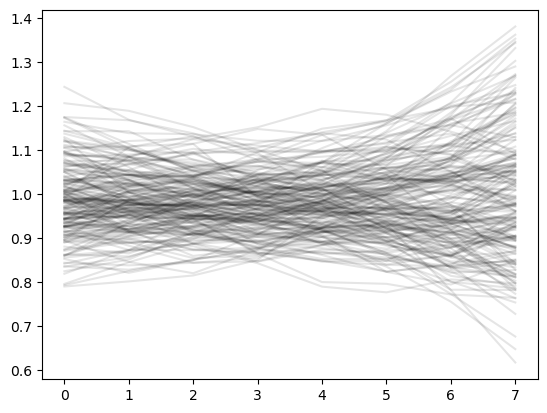

In [34]:
pl.figure()
for ji in range(kp2_all_data.shape[0]):
    pl.plot(kp2_all_data[ji,ind_filter_kp2]/kp2_all_fid[ind_filter_kp2], color='k', alpha=0.1)
pl.show()


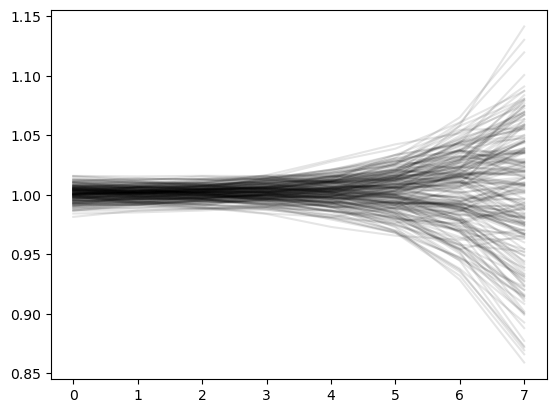

In [43]:
pl.figure()
for ji in range(kp2_all_data_normalised.shape[0]):
    pl.plot((kp2_all_data_normalised[ji,:]/kp2_fid_normalised)[0,:], color='k', alpha=0.1)
    # print(kp2_all_data_normalised[ji,:]/kp2_fid_normalised)
pl.show()



In [42]:
# kp2_all_data_normalised[ji,:]/kp2_fid_normalised
# kp2_all_data_normalised.shape
(kp2_all_data_normalised[ji,:]/kp2_fid_normalised).shape


(1, 8)

In [23]:
cov_mat_kp2sims_pca = np.cov(kp2_all_data_normalised_pcaonly.T)
cov_mat_kp3sims_pca = np.cov(kp3_all_data_normalised_pcaonly.T)



In [24]:
mean_kp2sims_pca = np.mean(kp2_all_data_normalised_pcaonly.T, axis=1)
mean_kp3sims_pca = np.mean(kp3_all_data_normalised_pcaonly.T, axis=1)




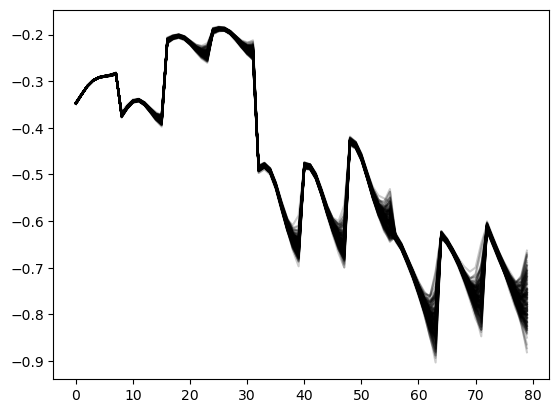

In [ ]:
# scaler_kp2_kp3 = StandardScaler().fit(kp2_kp3_all_lhs)
# kp2_kp3_all_lhs_normalised = scaler_kp2_kp3.transform(kp2_kp3_all_lhs)
pl.figure()
for ji in range(kp2_all_data_normalised.shape[0]):
    pl.plot(kp2_all_data_normalised[ji,:], color='k', alpha=0.2)
pl.show()


In [30]:
# scaler_kp2_kp3 = StandardScaler().fit(kp2_kp3_all_lhs)
# kp2_kp3_all_lhs_normalised = scaler_kp2_kp3.transform(kp2_kp3_all_lhs)
# pl.figure()
# for ji in range(kp2_all_data.shape[0]):
#     pl.plot(kp2_all_data[ji,:], color='k', alpha=0.2)
# pl.show()



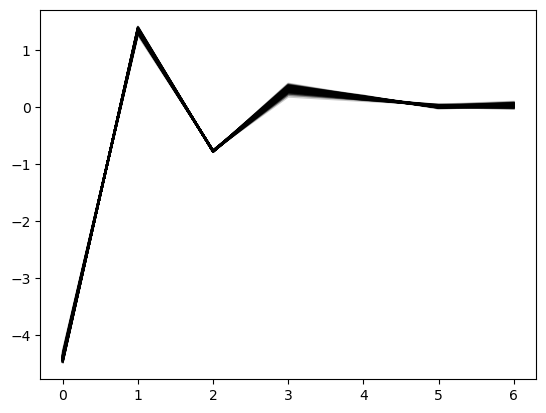

In [28]:
# scaler_kp2_kp3 = StandardScaler().fit(kp2_kp3_all_lhs)
# kp2_kp3_all_lhs_normalised = scaler_kp2_kp3.transform(kp2_kp3_all_lhs)
pl.figure()
for ji in range(kp2_all_data_normalised_pcaonly.shape[0]):
    pl.plot(kp2_all_data_normalised_pcaonly[ji,:], color='k', alpha=0.2)
pl.show()




In [181]:
# mean_kp2sims_pca
# kp2_all_data_normalised_pcaonly.shape
# mean_kp2sims_pca, kp2_fid_normalised_pcaonly
# mean_kp3sims_pca, kp3_fid_normalised_pcaonly
mean_kp2sims_pca, np.sqrt(np.diag(cov_mat_kp2sims_pca))



(array([-4.40959841,  1.35448876, -0.77313709,  0.32175476,  0.16426545,
         0.01115216,  0.03025774]),
 array([0.03874591, 0.02813421, 0.00668843, 0.03965256, 0.0169114 ,
        0.01322911, 0.02307066]))

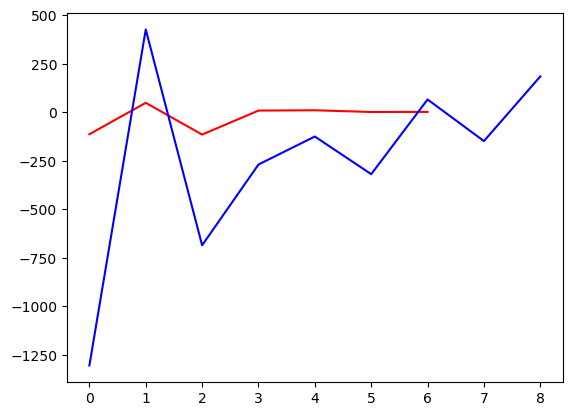

In [171]:
# pl.figure()
# pl.imshow(np.log(np.abs(cov_mat_kp2sims_pca)))
# pl.colorbar()
# pl.show()
pl.figure()
pl.plot(mean_kp2sims_pca/(np.sqrt(np.diag(cov_mat_kp2sims_pca))), color='r')
pl.plot(mean_kp3sims_pca/(np.sqrt(np.diag(cov_mat_kp3sims_pca))), color='b')
# pl.colorbar()
pl.show()




In [122]:
# pl.figure()
# pl.imshow(np.log(np.abs(cov_mat_kp2sims_pca)))
# pl.colorbar()
# pl.show()
# pl.figure()
# pl.plot(, color='r')
# pl.plot(mean_kp3sims_pca/(np.sqrt(np.diag(cov_mat_kp3sims_pca))), color='b')
# pl.colorbar()
# pl.show()




In [182]:
np.sqrt(np.matmul(mean_kp2sims_pca,np.matmul(np.linalg.inv(cov_mat_kp2sims_pca), mean_kp2sims_pca.T)))




773.0701688671384

In [143]:
# cov_mat_kp2sims_pca.shape
# mean_kp2sims_pca.shape
# np.linalg.inv(cov_mat_kp2sims_pca)
# np.matmul(np.linalg.inv(cov_mat_kp2sims_pca), mean_kp2sims_pca.T)



array([ -990498.61156453,  -647474.38326932, -1070921.95206287,
          38807.80325164,  -248438.69402118,   -95051.49396646,
          17857.67982453])

In [183]:
np.sqrt(np.matmul(mean_kp3sims_pca,np.matmul(np.linalg.inv(cov_mat_kp3sims_pca), mean_kp3sims_pca.T)))



4189.689813276016

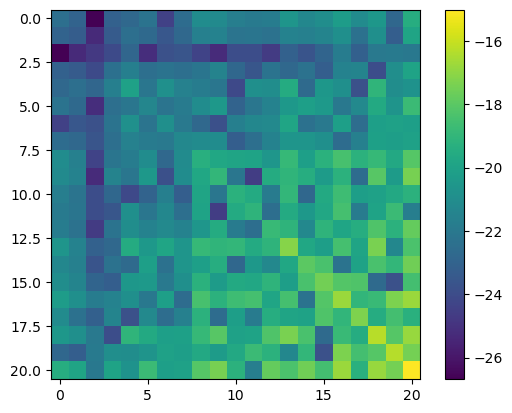

In [81]:
pl.figure()
pl.imshow(np.log(np.abs(cov_mat_kp3sims_pca)))
pl.colorbar()
pl.show()



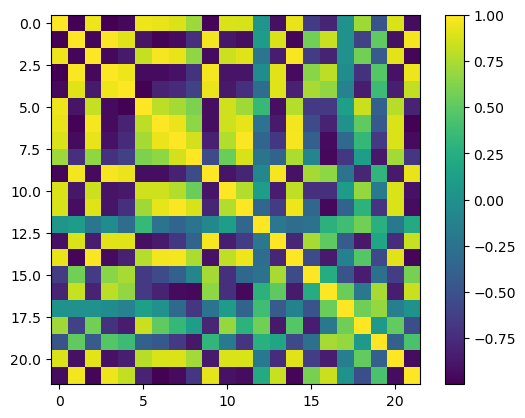

In [83]:
pl.figure()
pl.imshow(np.corrcoef((cov_mat_kp2sims_pca)))
pl.colorbar()
pl.show()



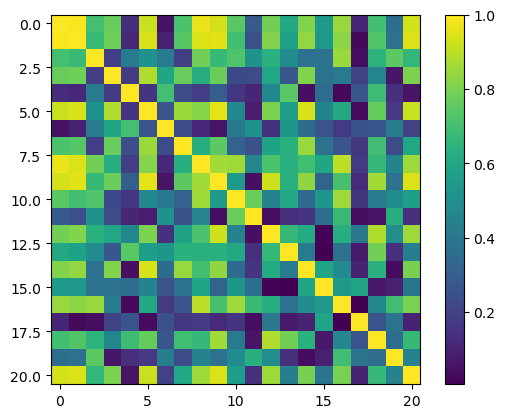

In [85]:
pl.figure()
pl.imshow(np.abs(np.corrcoef((cov_mat_kp3sims_pca))))
pl.colorbar()
pl.show()



In [37]:
# pl.figure()
# pl.imshow(cov_mat_kp2_norm)
# pl.colorbar()
# pl.show()

